In [30]:
try:
    print("Importing CUPY...")
    import cupy as cp

    print("done")
except Exception as xEx:
    print(
        "CUDA python module 'cupy' could not be imported.\n"
        "Make sure you have the NVIDIA CUDA toolkit installed and\n"
        "the 'cupy' module. See 'https://cupy.dev/' for more information.\n"
        "Note that if the 'pip' install does not work, try the 'conda' install option.\n\n"
        f"Exception reported:\n{(str(xEx))}"
    )
# endtry

import numpy as np

aA = np.array([1,2,3])
caA = cp.asarray(aA)
fLen = cp.linalg.norm(caA)

print(fLen)



Importing CUPY...
done
3.7416573867739413


In [31]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
import cv2

from typing import Tuple
import numpy as np
from pathlib import Path

# Set the path from where all images can be found as environment variable "CATH_DEV_MAIN".
# With PowerShell this can be done with: [System.Environment]::SetEnvironmentVariable("CATH_DEV_MAIN", "[path]", "User")
# You need to restart VS Code after setting the path from a VS Code terminal.
sPathMain = os.environ["CATH_DEV_MAIN"]
pathMain = Path(sPathMain)
# print(f"Main path: {pathMain}")

pathImage = pathMain / "Image"
pathDepth = pathMain / "AT_Depth/full_res/Radial"

iFrame: int = 10

def LoadImages(_iFrame:int) -> Tuple[np.ndarray, np.ndarray]:

    sFrame = f"Frame_{_iFrame:04d}"
    pathImgImage = pathImage / f"{sFrame}.png"
    pathImgDepth = pathDepth / f"{sFrame}.exr"

    imgImageOrig = cv2.imread(
        pathImgImage.as_posix(),
        cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH | cv2.IMREAD_UNCHANGED,
    )

    imgDepthOrig = cv2.imread(
        pathImgDepth.as_posix(),
        cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH | cv2.IMREAD_UNCHANGED,
    )

    imgImage = imgImageOrig[:, :, [2, 1, 0]]
    # imgDepth = imgDepthOrig[:, :, [2, 1, 0, 3]]

    return imgImage, imgDepthOrig
# enddef

imgImageOrig, imgDepth = LoadImages(iFrame)

fMaxImgVal = float(np.iinfo(imgImageOrig.dtype).max)
print(f"fMaxImgVal: {fMaxImgVal}")

print(f"Image Shape: {imgImageOrig.shape}")
print(f"Depth Shape: {imgDepth.shape}")

# Scale image value to range [0, 1]
# imgImage = imgImageOrig.astype(np.float32) / fMaxImgVal
imgImage = imgImageOrig

# aOffset = np.array([[[1e4, 1e4, 1e4]]])
# imgPos1 = imgPos1 - aOffset
# imgPos2 = imgPos2 - aOffset

# imgLoc1 = imgLoc1 - aOffset
# imgLoc2 = imgLoc2 - aOffset


# print(np.min(imgPos1))
# print(np.max(imgPos1))


fMaxImgVal: 255.0
Image Shape: (1000, 1000, 3)
Depth Shape: (1000, 1000)


In [4]:
print(f"CUDA device count: {(cp.cuda.runtime.getDeviceCount())}")

CUDA device count: 1


In [41]:
import sys
from pathlib import Path

pathKernel = Path.cwd() / "Dev-EvalDepthBlurSimple-v1.cu"
sKernelCode = pathKernel.read_text()

iThreadCnt = 32
tiFilterRadiusXY = (10, 10)
fFocusDepth_mm: float = 2.76e3
fFocalLength_mm: float = 100.0
fApertureDia_mm: float = 3.0
fPixelPitch_mm: float = 3e-3
fFocalPlanePos_mm: float = 1.0 / (1.0 / fFocalLength_mm - 1.0 / fFocusDepth_mm)
fMMperDepthUnit: float = 1e3


iDepthRows, iDepthCols = imgDepth.shape[0:2]
if len(imgDepth.shape) > 2:
    iDepthChanCnt = imgDepth.shape[2]
else:
    iDepthChanCnt = 1
#endif
iRowStrideDepth = iDepthCols * iDepthChanCnt

iImgRows, iImgCols = imgImage.shape[0:2]
if len(imgImage.shape) > 2:
    iImgChanCnt = imgImage.shape[2]
else:
    iImgChanCnt = 1
# endif
iRowStrideImage = iImgCols * iImgChanCnt

tiSizeXY = (iImgCols, iImgRows)
# Full image
tiStartXY = (0, 0)
tiRangeXY = (iImgCols, iImgRows)

tiRangeXY = tuple(tiRangeXY[i] if tiStartXY[i] + tiRangeXY[i] <= tiSizeXY[i] else tiSizeXY[i] - tiStartXY[0] for i in range(2))
tiBlockDimXY = (tiRangeXY[0] // iThreadCnt + (1 if tiRangeXY[0] % iThreadCnt > 0 else 0), tiRangeXY[1])

sFuncMbExp = (f"EvalDepthBlurSimple<{tiStartXY[0]}, {tiStartXY[1]}, "
                f"{tiRangeXY[0]}, {tiRangeXY[1]}, "
                f"{tiSizeXY[0]}, {tiSizeXY[1]}, "
                f"{tiFilterRadiusXY[0]}, {tiFilterRadiusXY[1]}, "
                f"{iRowStrideImage}, {iRowStrideDepth}, "
                f"{iImgChanCnt}, {iDepthChanCnt}>")
                
modKernel = cp.RawModule(code=sKernelCode, options=("-std=c++11",), name_expressions=[sFuncMbExp])
# modKernel.compile(log_stream=sys.stdout)
kernDepth = modKernel.get_function(sFuncMbExp)

caImage = cp.asarray(imgImage, dtype=cp.float32)
caDepth = cp.asarray(imgDepth, dtype=cp.float32)
caResult = cp.full((iImgRows, iImgCols, iImgChanCnt), 0.0, dtype=cp.float32)

tArgs = (caImage, 
         caDepth, 
         cp.float32(fFocusDepth_mm), 
         cp.float32(fFocalLength_mm), 
         cp.float32(fApertureDia_mm), 
         cp.float32(fPixelPitch_mm), 
         cp.float32(fFocalPlanePos_mm),
         cp.float32(fMMperDepthUnit),
         caResult)

kernDepth(tiBlockDimXY, (iThreadCnt,), tArgs)

imgResult = cp.asnumpy(caResult)
imgResultWrite = imgResult[:, :, [2, 1, 0]] / fMaxImgVal
cv2.imwrite((pathMain / f"DepthBlur_{iFrame}.exr").as_posix(), imgResultWrite)


True

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0.    0.003 0.006 0.009 0.012 0.015 0.018 0.021 0.024 0.027 0.03 ]
fAiryDiskRad_mm: 0.01914828431372584
aEnergyRatio: [1.         0.92181031 0.71595331 0.45458561 0.219233   0.06537794
 0.0040217  0.00753889 0.03293235 0.04699792 0.03949074]


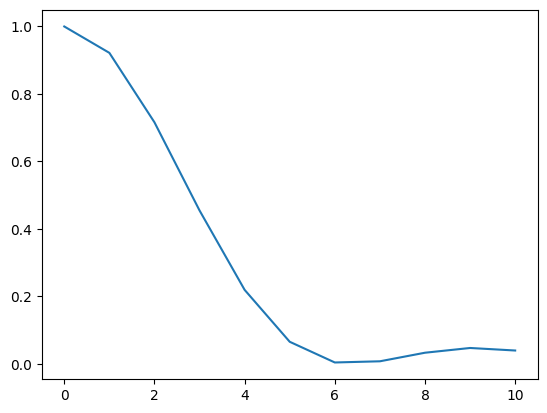

In [29]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

fDepthDelta_mm: float = 300
fFocusDepth_mm: float = 2.76e3
fFocalLength_mm: float = 200.0
fApertureDia_mm: float = 5.0
fPixelPitch_mm: float = 3e-3
fFocalPlanePos_mm: float = 1.0 / (1.0 / fFocalLength_mm - 1.0 / fFocusDepth_mm)
fMMperDepthUnit: float = 1e3
fPi: float = 3.14159265358979323846

def Func(aX_px: np.ndarray, fDepth_mm: float):

    aX_mm = fPixelPitch_mm * aX_px
    print(aX_mm)

    fAiryDiskRad_mm = 0.5 * max(fPixelPitch_mm, abs((1.0 - fFocalPlanePos_mm * (1.0 / fFocalLength_mm - 1.0 / fDepth_mm))) * fApertureDia_mm)
    print(f"fAiryDiskRad_mm: {fAiryDiskRad_mm}")

    # aPixRadMin_mm = np.clip(aX_mm - 0.5 * fPixelPitch_mm, 0.0, fAiryDiskRad_mm)
    # print(aPixRadMin_mm)

    # aPixRadMax_mm = np.clip(aX_mm + 0.5 * fPixelPitch_mm, 0.0, fAiryDiskRad_mm)
    # print(aPixRadMax_mm)

    # aRadRatio = np.clip((aPixRadMax_mm - aPixRadMin_mm) / fAiryDiskRad_mm, 0.0, None)
    # # aRadRatio = np.sinc(aX_mm / fAiryDiskRad_mm)
    # print(f"aRadRatio: {aRadRatio}")

    # aBandArea_mm2 = fPi * (np.square(aPixRadMax_mm)- np.square(aPixRadMin_mm))
    # print(f"aBandArea_mm2: {aBandArea_mm2}")

    # aPixPerBandArea = np.clip((fPixelPitch_mm * fPixelPitch_mm) / aBandArea_mm2, 0.0, 1.0)
    # print(f"aPixPerBandArea: {aPixPerBandArea}")

    # aEnergyRatio = aRadRatio * aPixPerBandArea
    aEnergyRatio = np.square(np.sinc(aX_mm / fAiryDiskRad_mm))
    print(f"aEnergyRatio: {aEnergyRatio}")

    return aEnergyRatio
# enddef

aX_px = np.linspace(0, 10, 11)
print(aX_px)

aY = Func(aX_px, fFocusDepth_mm + fDepthDelta_mm)

plt.plot(aX_px, aY)
plt.show()

